Loading CSV...
Analyzing trials with confusion matrix...

Total error counts:
Transposition Errors     489
Intrusion Errors         124
Omission Errors         1834
Substitution Errors       81
dtype: int64

Accuracy by serial position:
Position 1: 57.5% ({'correct': 138, 'substitution': 10, 'transposition': 30, 'omission': 51, 'intrusion': 11})
Position 2: 49.6% ({'correct': 119, 'substitution': 13, 'transposition': 41, 'omission': 55, 'intrusion': 12})
Position 3: 37.9% ({'correct': 91, 'transposition': 57, 'substitution': 9, 'intrusion': 10, 'omission': 73})
Position 4: 31.2% ({'transposition': 45, 'correct': 75, 'omission': 100, 'intrusion': 13, 'substitution': 7})
Position 5: 25.0% ({'transposition': 40, 'correct': 60, 'omission': 122, 'substitution': 8, 'intrusion': 10})
Position 6: 19.2% ({'transposition': 30, 'omission': 145, 'correct': 46, 'substitution': 7, 'intrusion': 12})
Position 7: 7.9% ({'transposition': 23, 'omission': 187, 'correct': 19, 'intrusion': 10, 'substitution

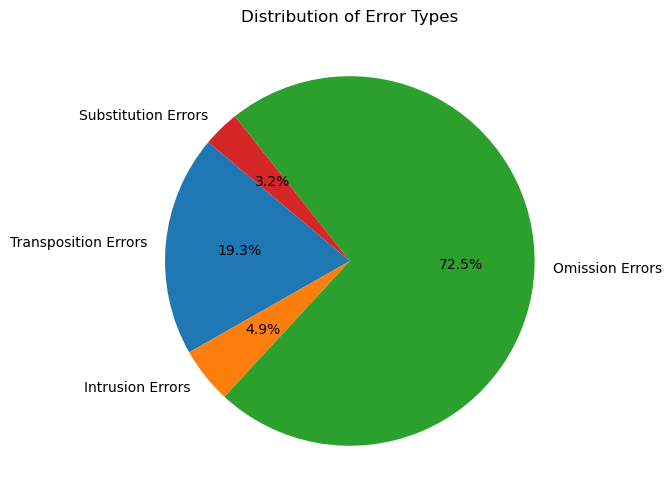

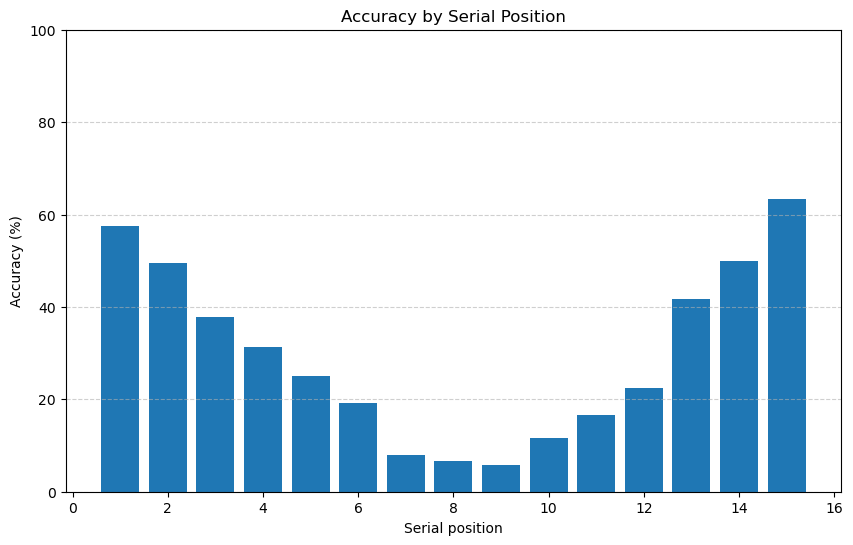

Creating confusion heatmaps...


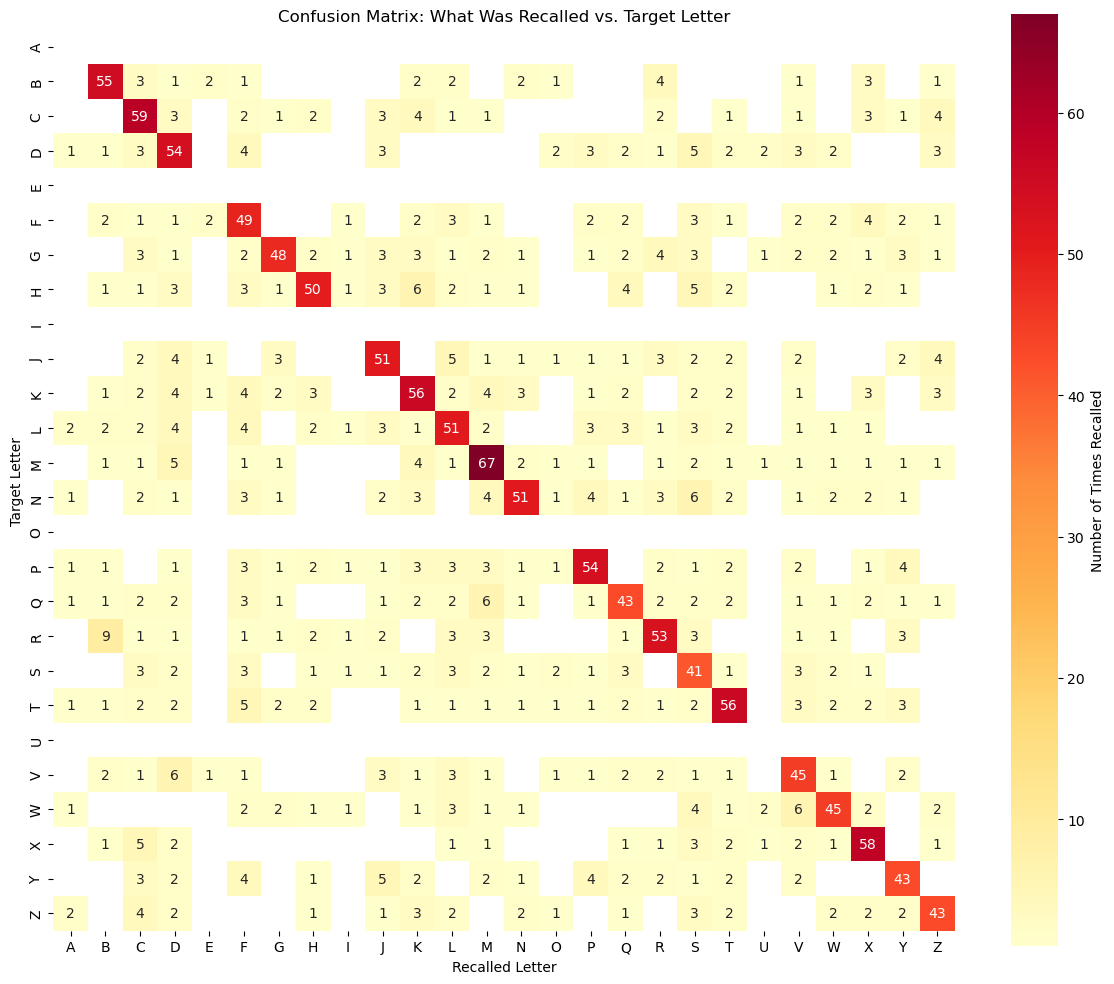

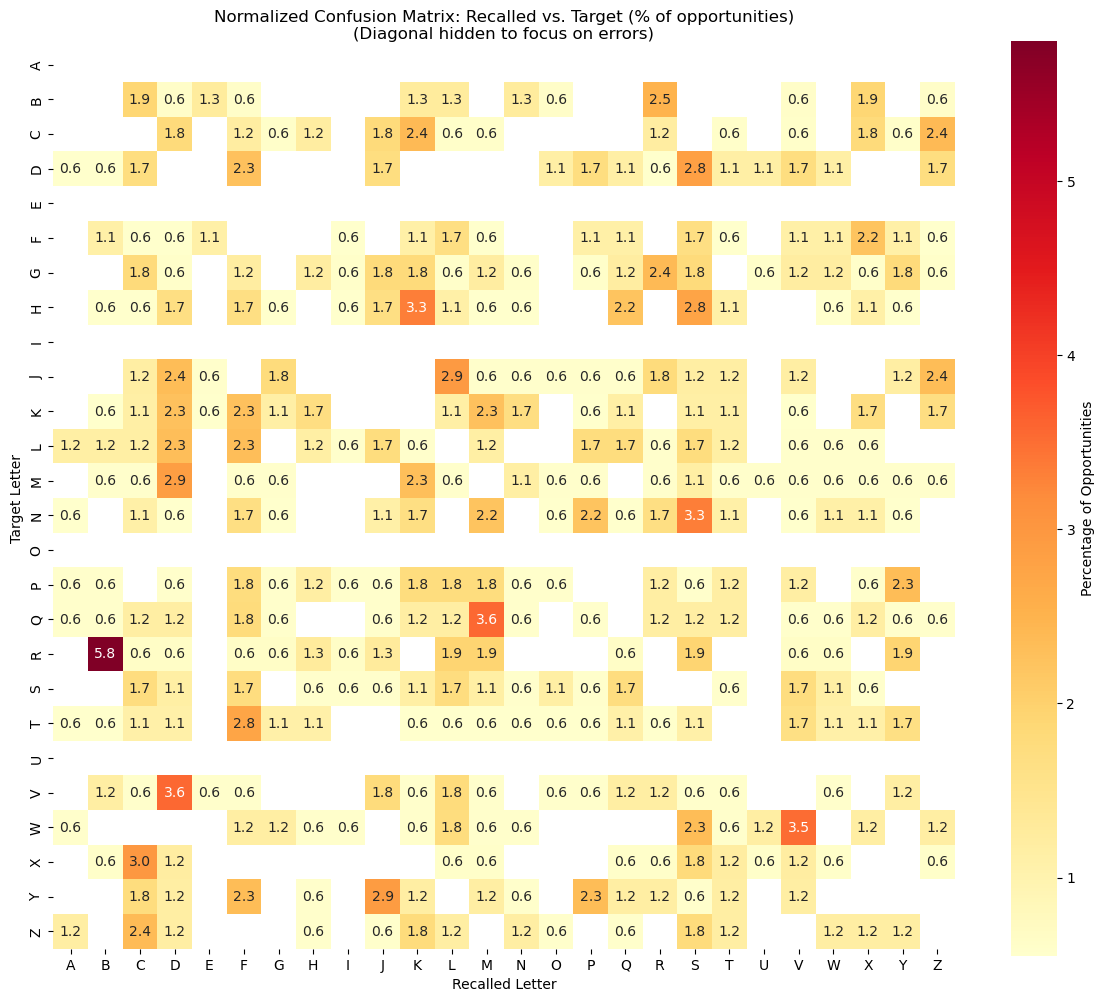


Confusion matrix includes 26 target letters
Raw counts heatmap and normalized percentage heatmap shown above


In [35]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from collections import Counter, defaultdict

# --- phonological groups used to detect "substitution" errors ---
PHON_GROUPS = [
    {"B", "P"},      # bilabial plosives
    {"D", "T"},      # alveolar plosives
    {"F", "V"},      # labiodental fricatives
    {"M", "N"},      # nasals
    {"S", "Z"},      # sibilant fricatives
    {"C", "K"},      # /k/ sounds
    {"G", "J"},      # voiced/affricate pair
    {"L", "R"}       # liquids
]


# --- visual similarity groups (consonants only, max 2 letters per group) ---
VISUAL_GROUPS = [
    {"B", "R"},   # looped stems (B & P is phon pair, so R used instead)
    {"D", "Q"},   # rounded bowls with tails
    {"H", "K"},   # tall vertical forms (K reused visually, distinct from phon pair)  
    {"G", "Y"},   # descenders/tails (G & J is phon pair)
    {"V", "W"},   # angular shapes (distinct from F–V phon pair)
    {"T", "F"},   # crossed stems
    {"S", "C"},   # curved or sinuous forms (instead of S–Z phon pair)
    {"X", "Z"}    # intersecting or diagonal shapes
]


def is_phonological_substitute(a, b):
    """Return True if letters a and b belong to the same phonological group."""
    for g in PHON_GROUPS:
        if a in g and b in g:
            return True
    return False

def is_visual_substitute(a, b):
    """Return True if letters a and b belong to the same visual similarity group."""
    for g in VISUAL_GROUPS:
        if a in g and b in g:
            return True
    return False

def is_similar_substitute(a, b):
    """Return True if letters are phonologically OR visually similar."""
    return is_phonological_substitute(a, b) or is_visual_substitute(a, b)

def load_clean_csv(path):
    """
    Read the CSV after cleaning quote issues — no temp files used.
    Returns a DataFrame with columns:
    ['trial','original','recalled','flags','correct_count','total']
    """
    with open(path, "r", encoding="utf-8") as f:
        text = f.read().replace('"""', '"')
    df = pd.read_csv(StringIO(text), header=None,
                     names=['trial','original','recalled','flags','correct_count','total'],
                     quotechar='"', skipinitialspace=True, engine='python')
    df['original'] = df['original'].astype(str).str.strip()
    df['recalled'] = df['recalled'].astype(str).str.strip()
    df['flags'] = df['flags'].astype(str).str.strip()
    return df

def clean_strings(orig_raw, recalled_raw):
    """Return cleaned uppercase original and recalled strings."""
    orig = re.sub(r'[^A-Za-z]', '', str(orig_raw)).upper()
    recalled = re.sub(r'[^A-Za-z0]', '', str(recalled_raw)).upper()
    return orig, recalled

def analyze_trial_with_confusion(orig, recalled):
    """Analyze one trial and track confusion matrix data."""
    trans = intr = omis = sub = 0
    orig_len = len(orig)
    recalled_len = len(recalled)
    pos_correct = []
    pos_types = []
    
    # For confusion matrix: track what was recalled for each original position
    position_recalls = []

    for i in range(orig_len):
        o = orig[i]
        r = recalled[i] if i < recalled_len else '0'

        if r == o:
            pos_correct.append(1)
            pos_types.append('correct')
            position_recalls.append((o, r, 'correct'))
            continue

        pos_correct.append(0)
        if r == '0' or r == '':
            omis += 1
            pos_types.append('omission')
            position_recalls.append((o, '0', 'omission'))
        elif is_similar_substitute(o, r):  # CHANGED: now includes both phonological AND visual
            sub += 1
            pos_types.append('substitution')
            position_recalls.append((o, r, 'substitution'))
        elif r in orig and orig.index(r) != i:
            trans += 1
            pos_types.append('transposition')
            position_recalls.append((o, r, 'transposition'))
        else:
            intr += 1
            pos_types.append('intrusion')
            position_recalls.append((o, r, 'intrusion'))

    # Extra recalled chars beyond original length → intrusion
    intr += sum(1 for j in range(orig_len, recalled_len) if recalled[j] != '0')

    return {
        'trans': trans, 'intr': intr, 'omis': omis, 'sub': sub,
        'pos_correct': pos_correct, 'pos_types': pos_types, 
        'orig_len': orig_len, 'position_recalls': position_recalls
    }

def analyze_dataframe_with_confusion(df):
    """Analyze all trials and build a confusion matrix."""
    trial_results = []
    
    # Build confusion matrix: original_letter -> recalled_letter -> count
    confusion_matrix = defaultdict(Counter)
    letter_total = Counter()
    
    # Also track overall counts for normalization
    total_opportunities = Counter()  # How many times each letter was presented
    total_correct = Counter()        # How many times each letter was correctly recalled

    for _, row in df.iterrows():
        orig, recalled = clean_strings(row['original'], row['recalled'])
        res = analyze_trial_with_confusion(orig, recalled)

        # Update confusion matrix and counts
        for orig_letter, recalled_letter, error_type in res['position_recalls']:
            letter_total[orig_letter] += 1
            total_opportunities[orig_letter] += 1
            
            if error_type == 'correct':
                total_correct[orig_letter] += 1
                confusion_matrix[orig_letter][recalled_letter] += 1
            elif error_type == 'substitution':
                confusion_matrix[orig_letter][recalled_letter] += 1
            elif error_type == 'transposition':
                confusion_matrix[orig_letter][recalled_letter] += 1
            elif error_type == 'intrusion':
                confusion_matrix[orig_letter][recalled_letter] += 1
            # Omissions are tracked separately

        trial_results.append({
            'original_clean': orig,
            'recalled_clean': recalled,
            'orig_len': res['orig_len'],
            'Transposition Errors': res['trans'],
            'Intrusion Errors': res['intr'],
            'Omission Errors': res['omis'],
            'Substitution Errors': res['sub'],
            'Position Correct': res['pos_correct'],
            'Position Types': res['pos_types']
        })

    results_df = pd.DataFrame(trial_results)
    agg_errors = results_df[['Transposition Errors','Intrusion Errors','Omission Errors','Substitution Errors']].sum()

    # --- Position accuracy ---
    max_pos = results_df['orig_len'].max() if len(results_df)>0 else 0
    position_accuracy = {}
    position_error_counts = {}

    for pos in range(max_pos):
        present_mask = results_df['orig_len'] > pos
        n_present = present_mask.sum()
        if n_present == 0:
            continue

        correct_count = sum(results_df.loc[present_mask, 'Position Correct'].apply(lambda lst: lst[pos]))
        position_accuracy[pos+1] = (correct_count / n_present) * 100

        error_counter = defaultdict(int)
        for lst_types in results_df.loc[present_mask, 'Position Types']:
            error_counter[lst_types[pos]] += 1
        position_error_counts[pos+1] = dict(error_counter)

    return results_df, agg_errors, position_accuracy, position_error_counts, confusion_matrix, total_opportunities, total_correct

def create_confusion_heatmap(confusion_matrix, total_opportunities):
    """Create a heatmap showing what letters were recalled for each target letter."""
    
    # Get all letters that appear in the data
    all_letters = sorted(set(confusion_matrix.keys()) | 
                         set(recalled for recalls in confusion_matrix.values() 
                             for recalled in recalls))
    
    # Create a matrix for the heatmap
    heatmap_data = np.zeros((len(all_letters), len(all_letters)))
    
    # Fill the matrix with counts
    for i, orig_letter in enumerate(all_letters):
        for j, recalled_letter in enumerate(all_letters):
            heatmap_data[i, j] = confusion_matrix[orig_letter][recalled_letter]
    
    # Convert to DataFrame for better labeling
    heatmap_df = pd.DataFrame(heatmap_data, 
                              index=all_letters, 
                              columns=all_letters)
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    
    # Use a mask to hide zeros for cleaner visualization
    mask = heatmap_data == 0
    
    sns.heatmap(heatmap_df, 
                annot=True, 
                fmt='.0f', 
                cmap='YlOrRd',
                mask=mask,
                cbar_kws={'label': 'Number of Times Recalled'},
                square=True)
    
    plt.title('Confusion Matrix: What Was Recalled vs. Target Letter')
    plt.xlabel('Recalled Letter')
    plt.ylabel('Target Letter')
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

def create_normalized_confusion_heatmap(confusion_matrix, total_opportunities):
    """Create a heatmap normalized by how often each target letter appeared."""
    
    all_letters = sorted(set(confusion_matrix.keys()) | 
                         set(recalled for recalls in confusion_matrix.values() 
                             for recalled in recalls))
    
    # Create normalized matrix (percentage of opportunities)
    normalized_data = np.zeros((len(all_letters), len(all_letters)))
    
    for i, orig_letter in enumerate(all_letters):
        total = total_opportunities[orig_letter]
        if total > 0:
            for j, recalled_letter in enumerate(all_letters):
                normalized_data[i, j] = (confusion_matrix[orig_letter][recalled_letter] / total) * 100
    
    normalized_df = pd.DataFrame(normalized_data, 
                                 index=all_letters, 
                                 columns=all_letters)
    
    # Create the normalized heatmap
    plt.figure(figsize=(12, 10))
    
    # Mask zeros and also mask the diagonal for error pattern focus
    mask = (normalized_data == 0) | (np.eye(len(all_letters)) == 1)
    
    sns.heatmap(normalized_df, 
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd',
                mask=mask,
                cbar_kws={'label': 'Percentage of Opportunities'},
                square=True)
    
    plt.title('Normalized Confusion Matrix: Recalled vs. Target (% of opportunities)\n(Diagonal hidden to focus on errors)')
    plt.xlabel('Recalled Letter')
    plt.ylabel('Target Letter')
    plt.tight_layout()
    plt.show()
    
    return normalized_df

def plot_results(agg_errors, position_accuracy, confusion_matrix, total_opportunities):
    """Display charts including confusion heatmaps."""
    total_errors = agg_errors.sum()
    if total_errors > 0:
        plt.figure(figsize=(6,6))
        plt.pie(agg_errors.values, labels=agg_errors.index, autopct='%1.1f%%', startangle=140)
        plt.title('Distribution of Error Types')
        plt.show()

    if position_accuracy:
        pos = list(position_accuracy.keys())
        acc = [position_accuracy[p] for p in pos]
        plt.figure(figsize=(10,6))
        plt.bar(pos, acc)
        plt.xlabel('Serial position')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy by Serial Position')
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
    
    # Create confusion heatmaps
    print("Creating confusion heatmaps...")
    raw_heatmap = create_confusion_heatmap(confusion_matrix, total_opportunities)
    normalized_heatmap = create_normalized_confusion_heatmap(confusion_matrix, total_opportunities)
    
    return raw_heatmap, normalized_heatmap

def print_confusion_analysis(confusion_matrix, total_opportunities, total_correct):
    """Print analysis of the confusion patterns."""
    print("\n" + "="*60)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*60)
    
    # Calculate accuracy for each letter
    print("\nLetter Accuracy:")
    for letter in sorted(total_opportunities.keys()):
        if total_opportunities[letter] > 0:
            accuracy = (total_correct[letter] / total_opportunities[letter]) * 100
            print(f"  {letter}: {accuracy:.1f}% ({total_correct[letter]}/{total_opportunities[letter]})")
    
    # Find most common confusions
    print("\nMost Common Confusions:")
    confusions = []
    for orig_letter in confusion_matrix:
        for recalled_letter, count in confusion_matrix[orig_letter].items():
            if orig_letter != recalled_letter and count > 0:  # Only errors
                is_phon = is_phonological_substitute(orig_letter, recalled_letter)
                is_vis = is_visual_substitute(orig_letter, recalled_letter)
                if is_phon and is_vis:
                    sim_type = " (phonological+visual)"
                elif is_phon:
                    sim_type = " (phonological)"
                elif is_vis:
                    sim_type = " (visual)"
                else:
                    sim_type = ""
                confusions.append((orig_letter, recalled_letter, count, sim_type))
    
    # Sort by frequency and show top 10
    confusions.sort(key=lambda x: x[2], reverse=True)
    for i, (orig, recalled, count, sim_type) in enumerate(confusions[:10], 1):
        print(f"  {i:2d}. {orig} → {recalled}: {count} times{sim_type}")

def print_similarity_groups():
    """Print the defined similarity groups for reference."""
    print("\n" + "="*60)
    print("DEFINED SIMILARITY GROUPS")
    print("="*60)
    print("\nPhonological Groups:")
    for i, group in enumerate(PHON_GROUPS, 1):
        print(f"  {i}. {', '.join(sorted(group))}")
    
    print("\nVisual Similarity Groups (consonants only, max 2 per group):")
    for i, group in enumerate(VISUAL_GROUPS, 1):
        print(f"  {i}. {', '.join(sorted(group))}")

if __name__ == '__main__':
    input_path = 'serial_recall_all.csv'

    print("Loading CSV...")
    df = load_clean_csv(input_path)

    print("Analyzing trials with confusion matrix...")
    results_df, agg_errors, position_accuracy, position_error_counts, confusion_matrix, total_opportunities, total_correct = analyze_dataframe_with_confusion(df)

    print("\nTotal error counts:")
    print(agg_errors)

    print("\nAccuracy by serial position:")
    for p, a in sorted(position_accuracy.items()):
        print(f"Position {p}: {a:.1f}% ({position_error_counts[p]})")

    # Print similarity groups for reference
    print_similarity_groups()

    # Print confusion analysis
    print_confusion_analysis(confusion_matrix, total_opportunities, total_correct)

    # Create plots and heatmaps
    raw_heatmap, normalized_heatmap = plot_results(agg_errors, position_accuracy, confusion_matrix, total_opportunities)
    
    # Print summary of heatmap data
    print(f"\nConfusion matrix includes {len(confusion_matrix)} target letters")
    print("Raw counts heatmap and normalized percentage heatmap shown above")